# Sentiment Analysis with Pinecone

Sentiment analysis, often known as opinion mining, is a technique used in natural language processing (NLP) to determine the emotional undertone of a text. This is a common method used by organizations to identify and group opinions about their product, service, and ideas. In this notebook, we will apply this technique to the hotel industry and understand customer perception and potential areas that need improvement. To do this, we will:

1.	Generate Sentiment labels and scores based on customer reviews.
2.	Store them in a Pinecone index as metadata (alongside respective text vectors).
3.	Query Pinecone index on selected areas and understand customer opinions.

Let's get started.


# Install Dependencies

In [ ]:
!pip install sentence_transformers pinecone-client==3.1.0 datasets seaborn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.0/211.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 7.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl 

# Load and Prepare Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/5-SentimentAnalysis-LLM
!ls

/content/drive/MyDrive/5-SentimentAnalysis-LLM
amazon_alexa.tsv  amazon_f_handson.ipynb  results


In [ ]:
import pandas as pd

df = pd.read_csv('amazon_alexa.tsv', sep='\t')
df.head(10)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1


In [ ]:
# keep only the first 800 characters from the reviews
df["verified_reviews"] = df["verified_reviews"].str[:800]
# glimpse the dataset
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [ ]:
df.dropna(inplace=True)

# Initialize Sentiment Analysis Model

RoBERTa model fine-tuned for sentiment analysis to analyze the reviews. The model can be loaded from the HuggingFace model hub as follows:

In [ ]:
import torch

# set device to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification
    )

model_id = "cardiffnlp/twitter-roberta-base-sentiment"

# load the model from huggingface
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=3
)

# load the tokenizer from huggingface
tokenizer = AutoTokenizer.from_pretrained(model_id)

# load the tokenizer and model into a sentiment analysis pipeline
nlp = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device
    )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

The sentiment analysis model returns `LABEL_0` for negative, `LABEL_1` for neutral and `LABEL_2` for positive labels. We can add them to a dictionary to easily access them when showing the results.

In [ ]:
labels = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

In [ ]:
# view review number 200
test_review = df["verified_reviews"][200]
test_review

'A great device'

In [ ]:
# get the sentiment label and score for review number 241
nlp(test_review)

[{'label': 'LABEL_2', 'score': 0.9444420337677002}]

# Initialize Retriever

A retriever model is used to embed passages and queries, and it creates embeddings such that queries and passages with similar meanings are close in the vector space. We will use a sentence-transformer model as our retriever.

In [ ]:
from sentence_transformers import SentenceTransformer

# load the model from huggingface
retriever = SentenceTransformer(
    'sentence-transformers/all-MiniLM-L6-v2',
    device=device
)
retriever

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

# Initialize Pinecone Index

Initializing Pinecone index. The Pinecone index stores vector representations of the passages which we can retrieve using another vector (the query vector). We first need to initialize our connection to Pinecone. For this, we need a free [API key](https://app.pinecone.io/), we initialize the connection like so:

In [ ]:
import os
from pinecone import Pinecone

# initialize connection to pinecone (get API key at app.pinecone.io)
#api_key = os.environ.get('3b874343-1940-47e8-a795-4c774306c9b1')

# configure client
pc = Pinecone(api_key='dd489dd2-9b1e-482a-928d-818beed6d64e')

Now we setup our index specification, this allows us to define the cloud provider and region where we want to deploy our index. You can find a list of all [available providers and regions here](https://docs.pinecone.io/docs/projects).

In [ ]:
from pinecone import ServerlessSpec

cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

Now we can create our vector index. We will name it `sentiment-mining` (feel free to choose any name you prefer). We specify the metric type as `cosine` and dimension as `384` as these are the vector space and dimensionality of the vectors generated by the retriever model.

In [ ]:
index_name = "sentiment-mining"

In [ ]:
import time

# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=384,
        metric='cosine',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
# view index stats
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

# Generate Embeddings and Upsert

We generate embeddings for all the reviews in the dataset. Alongside the embeddings, we also include the sentiment label and score in the Pinecone index as metadata. Later we will use this data to understand customer opinions.

Let's first write a helper function to generate sentiment labels and scores for a batch of reviews.

In [ ]:
def get_sentiment(reviews):
    # pass the reviews through sentiment analysis pipeline
    sentiments = nlp(reviews)
    # extract only the label and score from the result
    l = [labels[x["label"]] for x in sentiments]
    s = [x["score"] for x in sentiments]
    return l, s

In [ ]:
# get sentiment labels for few reviews
get_sentiment(df["verified_reviews"][:10].tolist())

(['positive',
  'positive',
  'positive',
  'positive',
  'neutral',
  'positive',
  'negative',
  'positive',
  'positive',
  'positive'],
 [0.983025312423706,
  0.9802091121673584,
  0.5947762727737427,
  0.97764652967453,
  0.6961960196495056,
  0.9735108017921448,
  0.44428789615631104,
  0.9735053777694702,
  0.974378764629364,
  0.9868482947349548])

We need to convert the review dates to timestamps to filter query results for a given period. This is helpful if you want to understand customer sentiment over a specific period. Let's write another helper function to convert dates to timestamps.

In [ ]:
import dateutil.parser

# convert date to timestamp
def get_timestamp(dates):
    timestamps = [dateutil.parser.parse(d).timestamp() for d in dates]
    return timestamps

In [ ]:
get_timestamp([df["date"][0]])[0]

1532995200.0

Now we create the embeddings. We do this in batches of `64` to avoid overwhelming machine resources or API request limits.

In [ ]:
from tqdm.auto import tqdm

# we will use batches of 64
batch_size = 64

for i in tqdm(range(0, len(df), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(df))
    # extract batch
    batch = df.iloc[i:i_end]
    # generate embeddings for batch
    emb = retriever.encode(batch["verified_reviews"].tolist()).tolist()
    # convert review_date to timestamp to enable period filters
    timestamp = get_timestamp(batch["date"].tolist())
    batch["timestamp"] = timestamp
    # get sentiment label and score for reviews in the batch
    label, score = get_sentiment(batch["verified_reviews"].tolist())
    batch["label"] = label
    batch["score"] = score
    # get metadata
    meta = batch.to_dict(orient="records")
    # create unique IDs
    ids = [f"{idx}" for idx in range(i, i_end)]
    # add all to upsert list
    to_upsert = list(zip(ids, emb, meta))
    # upsert/insert these records to pinecone
    _ = index.upsert(vectors=to_upsert)

# check that we have all vectors in index
index.describe_index_stats()

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-21-c151e2f6de72>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch["timestamp"] = timestamp
<ipython-input-21-c151e2f6de72>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch["label"] = label
<ipython-input-21-c151e2f6de72>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

We have successfully indexed all customer reviews and relevant metadata. We can move on to opinion mining.

# Opinion Mining

Now that we have all the customer reviews indexed, we will search for a few areas that customers usually consider when purchasing the alexa product and analyze the general opinion of the customers. Pinecone vector database makes it very flexible to do this as we can easily search for any topic and get customer reviews relevant to the search query along with sentiment labels as metadata.

We will start with a general question about the room sizes of hotels in London and return the top 500 reviews to analyze the overall customer sentiment.

In [ ]:
query = "are the customers satisfied with alexa?"
# generate dense vector embeddings for the query
xq = retriever.encode(query).tolist()
# query pinecone
result = index.query(vector=xq, top_k=500, include_metadata=True)

Let's take a look at a few reviews from the search results.

In [ ]:
result["matches"][:2]

[{'id': '2248',
  'metadata': {'date': '30-Jul-18',
               'feedback': 1.0,
               'label': 'positive',
               'rating': 5.0,
               'score': 0.9873065948486328,
               'timestamp': 1532908800.0,
               'variation': 'Configuration: Fire TV Stick',
               'verified_reviews': 'I bought and love them. Alexa is very '
                                   'convenient.'},
  'score': 0.820374489,
  'values': []},
 {'id': '675',
  'metadata': {'date': '20-May-18',
               'feedback': 1.0,
               'label': 'positive',
               'rating': 5.0,
               'score': 0.9745407700538635,
               'timestamp': 1526774400.0,
               'variation': 'Black',
               'verified_reviews': 'I have never been more satisfied with a '
                                   'product. Perfect introduction to Alexa.'},
  'score': 0.814044595,
  'values': []}]

In [ ]:
def count_sentiment(result):
    # store count of sentiment labels
    sentiments = {
        "negative": 0,
        "neutral": 0,
        "positive": 0,
    }
    # iterate through search results
    for r in result["matches"]:
        # extract the sentiment label and increase its count
        sentiments[r["metadata"]["label"]] += 1
    return sentiments

In [ ]:
sentiment = count_sentiment(result)
sentiment

{'negative': 61, 'neutral': 37, 'positive': 402}

Let's plot the result for a better view.

<Axes: >

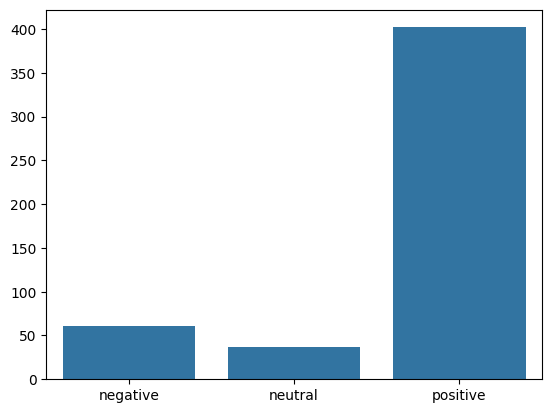

In [ ]:
import seaborn as sns

# plot a barchart using seaborn
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))

We can be even more specific when searching for reviews with the help of Pinecone's metadata filtering. For instance, we can specify a period in our query to ensure that search results only contain customer reviews for that period. This is helpful if you want to understand the customer's opinion during a specific period.

Let's do this for the same query as before. We will filter reviews from 25th July to 27th July 2018. Previously we added the `review_date` field as a timestamp to the metadata during indexing. We can convert the start and end date of the period to timestamp using the `get_timestamp` function and use a `$gte` (greater than or equal to) and a `$lte` (less than or equal to) filter to get reviews from only the selected period.

In [ ]:
# generate timestamps for start and end time of the period
start_time = get_timestamp(["2018-07-25"])[0]
end_time = get_timestamp(["2018-07-27"])[0]

<Axes: >

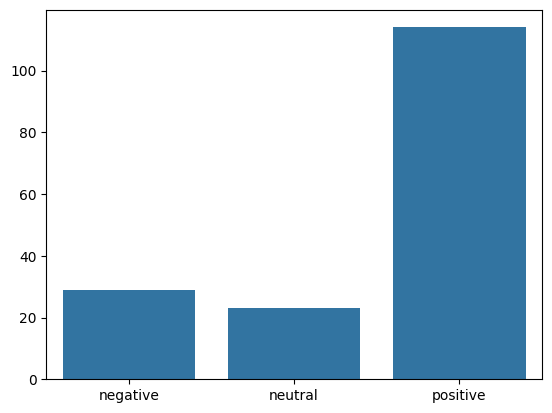

In [ ]:
query = "are the customers in India satisified with alexa's performance and quality?"
# generate query embeddings
xq = retriever.encode(query).tolist()
# query pinecone with query embeddings and the period filter
result = index.query(
    vector=xq,
    top_k=500,
    include_metadata=True,
    filter={"timestamp": {"$gte": start_time, "$lte":end_time}})
# get an overall count of customer sentiment
sentiment = count_sentiment(result)
# plot a barchart using seaborn
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))

We have a slightly different result now. Almost the same number of customers had either a neutral or negative view of the alexa's performance during the selected period.

In [ ]:
amazon_product =["Alexa"]

We will look into five main areas:
  1. Sound Quality
  2. Responsiveness
  3. Compatability
  4. Functionality
  5. Connectivity

We have a query for each of these areas below.

In [ ]:
queries = {
  "Sound Quality": "Are customers happy with the sound quality of Alexa speakers?",
  "Responsiveness": "Are customers satisfied with how quickly Alexa responds to their requests?",
  "Compatability": "How easy is it for customers to set up and use Alexa with their smart home devices?",
  "Functionality": "Does Alexa offer a wide variety of skills and functionalities?",
  "Connectivity": "Are customers satisfied with the reliability of Alexa's connection?",
}

We need to iterate through all the hotels and run these queries. This would give us customer reviews relevant to the Alexa product.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
alexa_sentiments = []

# iterate through the hotels
for h in amazon_product:
    result = []
    # iterate through the keys and values in the queries dict
    for area, query in queries.items():
        # generate query embeddings
        xq = retriever.encode(query).tolist()
        # query pinecone with query embeddings and the hotel filter
        xc = index.query(vector=xq, top_k=500, include_metadata=True, filter={"Product": h})
        # get an overall count of customer sentiment
        sentiment = count_sentiment(xc)
        # sort the sentiment to show area and each value side by side
        for k, v in sentiment.items():
            data = {
                "area": area,
                "label": k,
                "value": v
            }
            # add the data to result list
            result.append(data)
    # convert the
    alexa_sentiments.append({"Product": h, "df": pd.DataFrame(result)})


Let's see what our final data look like.

In [ ]:
alexa_sentiments[0]["df"]

,area,label,value
0,Sound Quality,negative,0
1,Sound Quality,neutral,0
2,Sound Quality,positive,0
3,Responsiveness,negative,0
4,Responsiveness,neutral,0
5,Responsiveness,positive,0
6,Compatability,negative,0
7,Compatability,neutral,0
8,Compatability,positive,0
9,Functionality,negative,0


# Delete Index

Delete the index if you're finished to save resources:

In [ ]:
pc.delete_index(index_name)

---